In [2]:
import os
#os.environ['THEANO_FLAGS'] = 'optimizer=None'
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from keras.models import Sequential, Model
from keras.optimizers import SGD
from keras.layers import Input, Activation, Dense, Convolution2D, MaxPooling2D, Dropout, Flatten
from keras.utils import np_utils
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd
import sys
import glob
import matplotlib.pyplot as plt
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

In [3]:
from root_numpy import root2array, tree2array
from root_numpy.testdata import get_filepath
import h5py

In [43]:
treename = 'HZZ4LeptonsAnalysisReduced'
VARS = ['f_massjj','f_deltajj']
filename = {}
h5file = {}
params = {}
df = {}

filename['VV'] = '../data/ntuple_4mu_VV.h5'
filename['gg'] = '../data/ntuple_4mu_gg.h5'

h5file['VV'] = h5py.File(filename['VV'], 'r') # open read-only
params['VV'] = h5file['VV'][treename][()]
h5file['gg'] = h5py.File(filename['gg'], 'r') # open read-only
params['gg'] = h5file['gg'][treename][()]

df['VV'] = pd.DataFrame(params['VV'],columns=VARS)
df['gg'] = pd.DataFrame(params['gg'],columns=VARS)

df['VV']= df['VV'][(df['VV'].f_massjj > 0) & (df['VV'].f_deltajj > 0)] # cut out undefined variables
df['gg']= df['gg'][(df['gg'].f_massjj > 0) & (df['gg'].f_deltajj > 0)] # cut out undefined variables

df['VV']['isSignal'] = np.ones(len(df['VV'])) # add isSignal variable
df['gg']['isSignal'] = np.zeros(len(df['gg'])) # add isSignal variable

print df['VV'].iloc[:5] # print first 5 entries
print df['gg'].iloc[:5] # print first 5 entries

      f_massjj  f_deltajj  isSignal
0  1300.426880   5.128572       1.0
1   437.221863   3.278692       1.0
3  1021.744080   5.989169       1.0
4  1101.381958   5.170628       1.0
7   498.717194   4.895020       1.0
      f_massjj  f_deltajj  isSignal
4   121.394302   0.235953       0.0
8   127.803024   2.774860       0.0
12   76.221428   0.730752       0.0
15   95.511597   1.546654       0.0
18   26.986721   0.283680       0.0


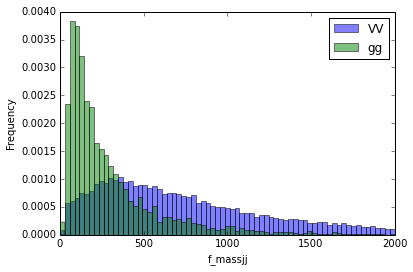

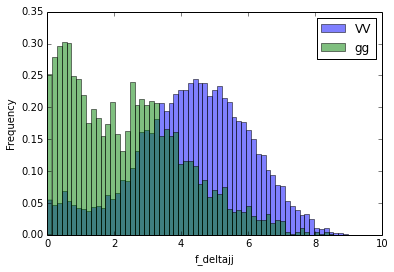

In [23]:
%matplotlib inline
plt.figure()
plt.xlabel(VARS[0])
bins = np.linspace(0, 2000, 70)
df['VV'][VARS[0]].plot.hist(bins, alpha=0.5, label='VV',normed=True)
df['gg'][VARS[0]].plot.hist(bins, alpha=0.5, label='gg',normed=True)
plt.legend(loc='upper right')
plt.figure()
plt.xlabel(VARS[1])
bins = np.linspace(0, 10, 70)
df['VV'][VARS[1]].plot.hist(bins, alpha=0.5, label='VV',normed=True)
df['gg'][VARS[1]].plot.hist(bins, alpha=0.5, label='gg',normed=True)
plt.legend(loc='upper right')

In [48]:
# baseline model
NDIM = len(VARS)
def create_baseline():
    # This returns a tensor
    inputs = Input(shape=(NDIM,))    
    x = Dense(20, init='normal', activation='relu')(inputs)
    x = Dropout(0.20)(x)
    x = Dense(20, init='normal', activation='relu')(x)
    x = Dropout(0.20)(x)
    predictions = Dense(1, init='normal', activation='sigmoid')(x)
    # This creates a model that includes
    # the input layer and two dense layers (one output)
    model = Model(input=inputs, output=predictions)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = create_baseline()
model.summary()

/Library/Python/2.7/site-packages/ipykernel/__main__.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(20, activation="relu", kernel_initializer="normal")`
/Library/Python/2.7/site-packages/ipykernel/__main__.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(20, activation="relu", kernel_initializer="normal")`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_19 (Dense)             (None, 20)                60        
_________________________________________________________________
dropout_5 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 20)                420       
_________________________________________________________________
dropout_6 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 21        
Total params: 501
Trainable params: 501
Non-trainable params: 0
_________________________________________________________________


/Library/Python/2.7/site-packages/ipykernel/__main__.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="normal")`
/Library/Python/2.7/site-packages/ipykernel/__main__.py:13: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`


In [49]:
df_all = pd.concat([df['VV'],df['gg']])
dataset = df_all.values
X = dataset[:,0:NDIM].astype(float)
Y = dataset[:,NDIM]
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)

kfold = StratifiedKFold(n_splits=2, shuffle=True,  random_state=seed)
    
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

/Library/Python/2.7/site-packages/ipykernel/__main__.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(20, activation="relu", kernel_initializer="normal")`
/Library/Python/2.7/site-packages/ipykernel/__main__.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(20, activation="relu", kernel_initializer="normal")`
/Library/Python/2.7/site-packages/ipykernel/__main__.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="sigmoid", kernel_initializer="normal")`
/Library/Python/2.7/site-packages/ipykernel/__main__.py:13: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`
/Library/Python/2.7/site-packages/ipykernel/__main__.py:16: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 9436 samples, validate on 9438 samples
Epoch 1/100
9436/9436 [==============================] - 1s - loss: 0.3980 - acc: 0.8233 - val_loss: 0.3812 - val_acc: 0.8297
Epoch 2/100
9436/9436 [==============================] - 1s - loss: 0.3886 - acc: 0.8298 - val_loss: 0.3787 - val_acc: 0.8297
Epoch 3/100
9436/9436 [==============================] - 1s - loss: 0.3920 - acc: 0.8298 - val_loss: 0.3815 - val_acc: 0.8297
Epoch 4/100
9436/9436 [==============================] - 1s - loss: 0.3882 - acc: 0.8298 - val_loss: 0.3783 - val_acc: 0.8297
Epoch 5/100
9436/9436 [==============================] - 1s - loss: 0.3879 - acc: 0.8298 - val_loss: 0.3787 - val_acc: 0.8297
Epoch 6/100
9436/9436 [==============================] - 1s - loss: 0.3892 - acc: 0.8298 - val_loss: 0.3780 - val_acc: 0.8297
Epoch 7/100
9436/9436 [==============================] - 1s - loss: 0.3868 - acc: 0.8298 - val_loss: 0.3824 - val_acc: 0.8297
Epoch 8/100
9436/9436 [==============================] - 1s - loss: 0.

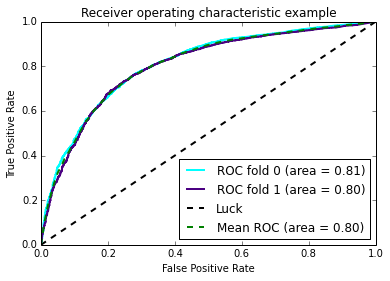

In [50]:
# Run classifier with cross-validation and plot ROC curves
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from scipy import interp

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)

colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange', 'red', 'black', 'green', 'brown'])
lw = 2

i = 0
histories = []
for (train, test), color in zip(kfold.split(X, encoded_Y), colors):
    model = create_baseline()
    history = model.fit(X[train], encoded_Y[train], validation_data=(X[test], encoded_Y[test]), nb_epoch=100, batch_size=32, verbose=1, callbacks=[early_stopping])
    Y_score = model.predict(X[test])
    histories.append(history)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(encoded_Y[test], Y_score)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=lw, color=color, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k', label='Luck')
mean_tpr /= kfold.get_n_splits(X, encoded_Y)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--',label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)
plt.xlim([0, 1.0])
plt.ylim([0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [55]:
df_all['dense'] = model.predict(X) # add prediction to array
print df_all.iloc[:5]

      f_massjj  f_deltajj  isSignal     dense
0  1300.426880   5.128572       1.0  0.958264
1   437.221863   3.278692       1.0  0.786792
3  1021.744080   5.989169       1.0  0.945267
4  1101.381958   5.170628       1.0  0.943236
7   498.717194   4.895020       1.0  0.851568


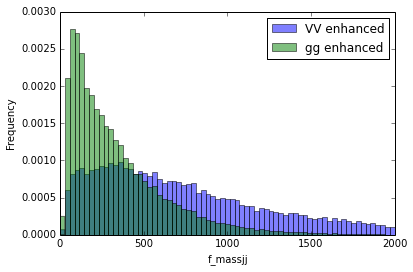

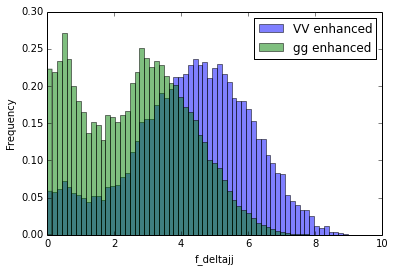

In [59]:
plt.figure()
plt.xlabel(VARS[0])
bins = np.linspace(0, 2000, 70)
df_all[VARS[0]].plot.hist(bins, alpha=0.5, label='VV enhanced',normed=True,  weights = df_all['dense'])
df_all[VARS[0]].plot.hist(bins, alpha=0.5, label='gg enhanced',normed=True,  weights = 1.-df_all['dense'])
plt.legend(loc='upper right')
plt.figure()
plt.xlabel(VARS[1])
bins = np.linspace(0, 10, 70)
df_all[VARS[1]].plot.hist(bins, alpha=0.5, label='VV enhanced',normed=True,  weights = df_all['dense'])
df_all[VARS[1]].plot.hist(bins, alpha=0.5, label='gg enhanced',normed=True,  weights = 1.-df_all['dense'])
plt.legend(loc='upper right')